In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from collections import defaultdict

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta

from dateutil.parser import parse as date_parse
import numpy as np
import pandas as pd

from collections import namedtuple
from glob import glob
from astropy.io import fits
from astropy.table import Table

from tqdm import tqdm_notebook

from piaa import exoplanets
import exodata

In [2]:
import requests

In [3]:
endpoint = 'https://us-central1-panoptes-survey.cloudfunctions.net/get-observations-data'

In [4]:
res = requests.get(endpoint)

In [5]:
res.ok

True

In [6]:
sequence_list = res.json()['items']

In [7]:
sequences = pd.DataFrame(sequence_list).set_index(['field']).drop('coord_bounds', axis=1)

In [8]:
# Adjust the time cells and add a midpoint
sequences.start_date = pd.to_datetime(sequences.start_date)
sequences.first_image_time = pd.to_datetime(sequences.first_image_time)
sequences.last_image_time = pd.to_datetime(sequences.last_image_time)
sequences['midpoint'] = sequences.first_image_time +(sequences.last_image_time - sequences.first_image_time) / 2

In [9]:
sequences.head()

,exp_time,first_image_time,id,image_count,last_image_time,piaa_state,pocs_version,ra_rate,start_date,unit_id,midpoint
field,,,,,,,,,,,
M42,120.3,2018-10-23 14:17:47,PAN001_ee04d1_20181023T141457,15,2018-10-23 14:57:37,fits_received,POCSv0.6.2,1.0,2018-10-23 14:14:57,1,2018-10-23 14:37:42
M42,120.0,2018-10-23 14:17:47,PAN001_14d3bd_20181023T141457,15,2018-10-23 14:57:37,fits_received,POCSv0.6.2,1.0,2018-10-23 14:14:57,1,2018-10-23 14:37:42
Wasp35,120.0,2018-10-23 10:57:48,PAN001_14d3bd_20181023T105620,70,2018-10-23 14:12:12,fits_received,POCSv0.6.2,1.0,2018-10-23 10:56:20,1,2018-10-23 12:35:00
Wasp35,120.3,2018-10-23 10:57:48,PAN001_ee04d1_20181023T105620,70,2018-10-23 14:12:12,fits_received,POCSv0.6.2,1.0,2018-10-23 10:56:20,1,2018-10-23 12:35:00
Wasp50,120.3,2018-10-23 08:05:24,PAN001_ee04d1_20181023T080343,60,2018-10-23 10:53:34,fits_received,POCSv0.6.2,1.0,2018-10-23 08:03:43,1,2018-10-23 09:29:29


In [11]:
# Remove some entries that didn't have a field name
sequences = sequences.iloc[sequences.index.values != None]

In [12]:
# Weed out sequences with less than 45 minutes
sequences = sequences.loc[(sequences.last_image_time - sequences.first_image_time) > '00:45:00']

In [13]:
# Mapping of our names to matching names in Exoplanet Orbit Database
name_mapping = {
    'Corot18': 'Corot-18 b',
    'Corot2': 'Corot-2 b',
    'HatP1': 'Hat-P-1 b',
    'HatP12': 'Hat-P-12 b',
    'HatP14': 'Hat-P-14 b',
    'HatP19': 'Hat-P-19 b',
    'HatP19B': 'Hat-P-19 b',
    'HatP20': 'Hat-P-20 b',
    'HatP36': 'Hat-P-36 b',
    'Hd189733': 'Hd189733 b',
    'Hd209458': 'Hd209458 b',
    'Kepler1100': 'Kepler-1100 b',
    'Kepler488': 'Kepler-488 b',
    'Kepler488B': 'Kepler-488 b',
    'Qatar1': 'Qatar-1 b',
    'Tres3': 'Tres-3 b',
    'Wasp11': 'Wasp-11 b',
    'Wasp2': 'Wasp-2 b',
    'Wasp24': 'Wasp-24 b',
    'Wasp33': 'Wasp-33 b',
    'Wasp35': 'Wasp-35 b',
    'Wasp44': 'Wasp-44 b',
    'Wasp50': 'Wasp-50 b',
    'Wasp52': 'Wasp-52 b',
    'Wasp69': 'Wasp-69 b',
    'Wasp74': 'Wasp-74 b',
    'Wasp77': 'Wasp-77 A b',
}

In [14]:
transits = defaultdict(list)
errors = dict()

for field, row in tqdm_notebook(sequences.iterrows(), total=len(sequences)):
    if field not in name_mapping:
        continue
        
    planet = exoplanets.Exoplanet(name_mapping[field])
    t0 = row.first_image_time
    
    try:
        if planet.transit_duration.value == 0:
            k = '{}_duration'.format(planet.name)
            if k not in errors:
                print("No duration for", planet.name)
                errors[k] = True
            continue

        if planet.midtransit.value == 0:
            k = '{}_midpoint'.format(planet.name)
            if k not in errors:
                print("No midpoint for", planet.name)
                errors[k] = True
            continue        

        if planet.period.value == 0:
            k = '{}_period'.format(planet.name)
            if k not in errors:
                print("No period for", planet.name)
                errors[k] = True
            continue                
    except Exception as e:
        if str(e) not in errors:
            print(e)
            errors[str(e)] = True                
    
    # Determine if in transit
    try:
        in_t = planet.in_transit([row.first_image_time, row.midpoint, row.last_image_time], with_times=True)
    except Exception as e:
        if str(e) not in errors:
            print(e)
            errors[str(e)] = True        
        continue    

    if in_t[0]:
        transits[field].append({'image_id': row.id, 'transit': in_t[1], 'planet': planet, 'images': [row.first_image_time, row.last_image_time]})
    

In [24]:
# Three subplots sharing both x/y axes

fig = Figure()
FigureCanvas(fig)

num_transits = np.sum([len(t) for t in transits.values()])
axes = fig.subplots(num_transits, sharey=True)
fig.set_size_inches(12, 2 * num_transits)

i = 0
for field, field_transits in sorted(transits.items()):
    for transit_info in field_transits:

        try:
            ax = axes[i]
        except Exception:
            ax = axes

        t = transit_info['transit']
        planet = transit_info['planet']
        images = transit_info['images']

        ingress = t[0][0]
        egress = t[0][1]
        ax.axvline(planet.get_phase(ingress), 0, color='r', ls='--', alpha=0.5, label='ingress')
        ax.axvline(planet.get_phase(egress), 0, color='r', ls='--', alpha=0.5, label='egress')

        start_images = planet.get_phase(Time(images[0]))
        end_images = planet.get_phase(Time(images[1]))

        ax.plot([start_images, end_images], [1, 1], label='Images')

        ax.legend()

        try:
            ax.set_title("{} {} {}".format(planet.name, transit_info['image_id'], planet.star_mag))
        except Exception as e:
            print(e)
        
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(0.5, 1.5)
        ax.get_yaxis().set_ticks([])

        fig.subplots_adjust(hspace=0)
        i +=1 
    
# f.savefig(txt_fn.replace('.txt', '_transits.png'))

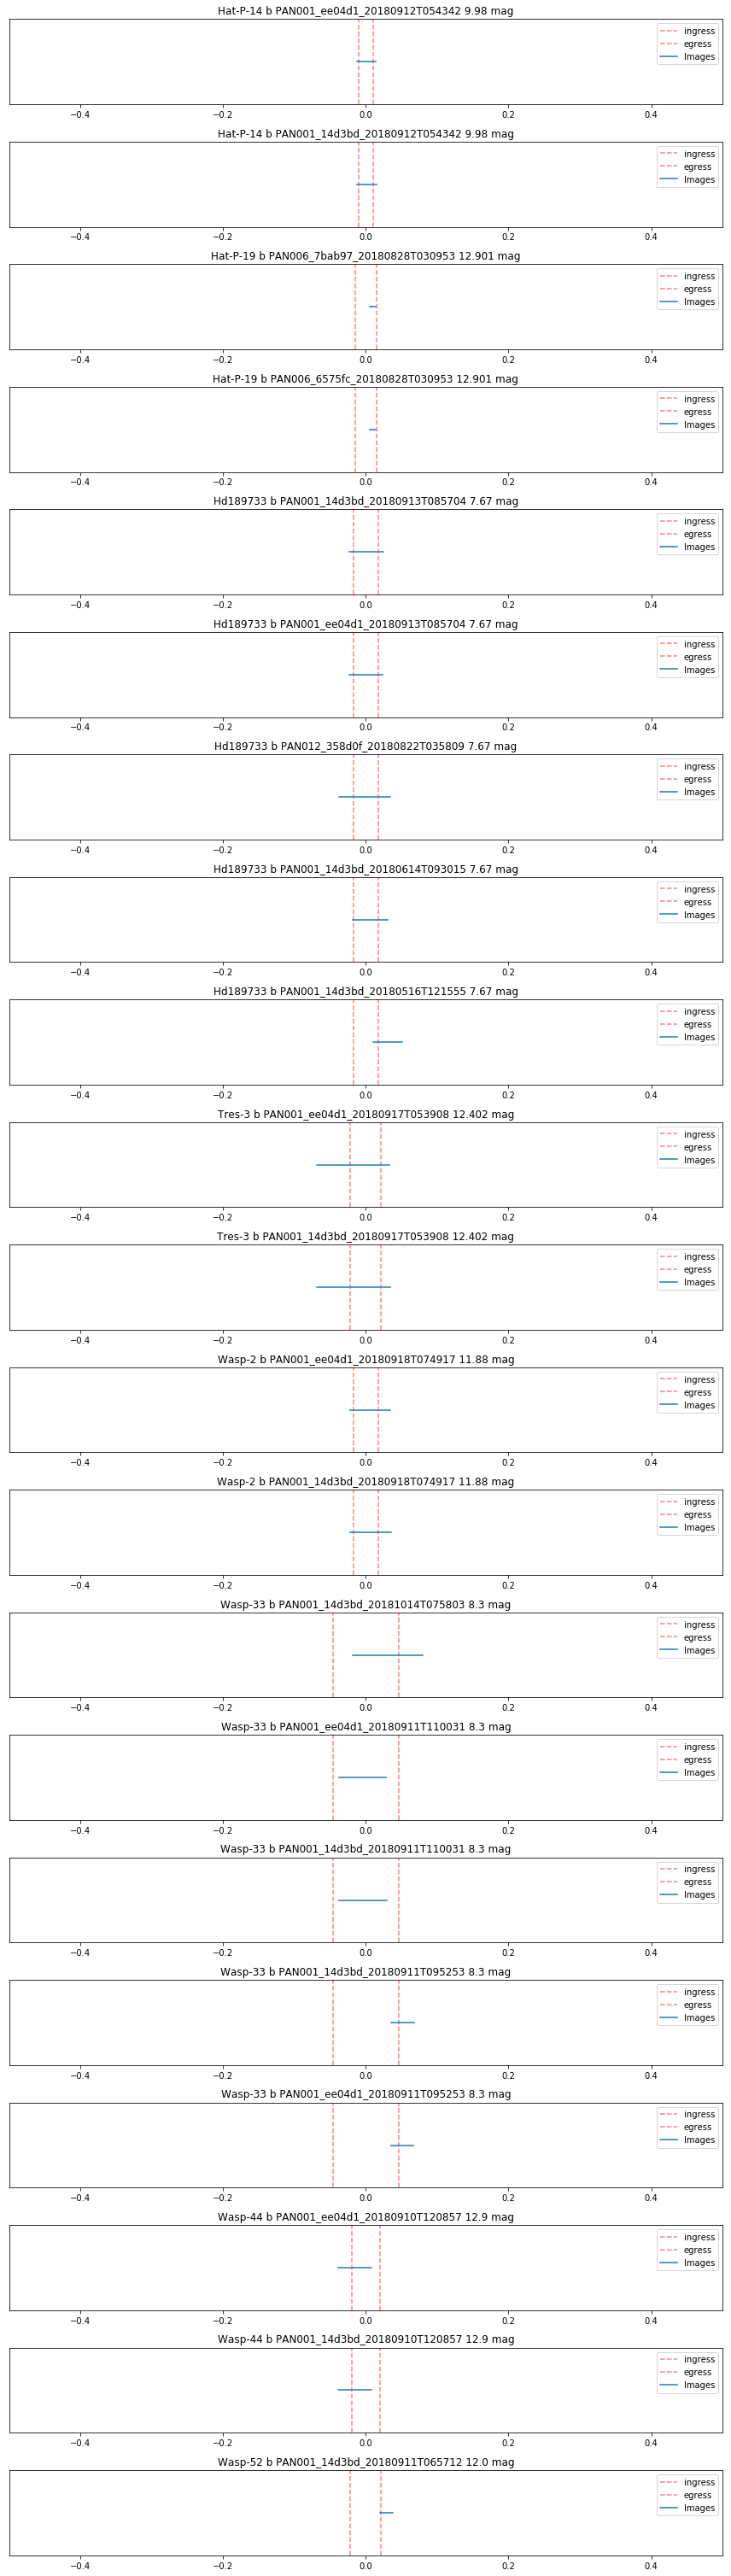

In [25]:
display(fig)